In [1]:
from collections import Counter
import datetime
import functools
import itertools
import os
from pathlib import Path

import re
import string
from timeit import default_timer
import warnings; warnings.simplefilter('ignore')

import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import silhouette_score

from utils import *
from graph_utils import *
from series_utils import *
from topic_utils import *

In [2]:
import warnings
warnings.simplefilter('ignore')

In [3]:
%matplotlib notebook
plt.style.use("bmh")

pd.options.display.float_format = '{:.2f}'.format

In [4]:
counts = ['like_count',
         'quote_count',
         'reply_count',
         'retweet_count',
         ]
plot_stats = ['mean',
             'std',
             ]
stats = ['mean',
         'std',
         'min',
         'max',
        ]

## Data: multiple campaigns
Using data from campaigns in Iran in September 2020 and December 2020

In [5]:
users = UsersData('data/users')
tweets = TweetsData('data/tweets')
df = tweets.df.loc[:][:]
user_df = users.df.loc[:][:]

In [6]:
campaign = df[df['government'] == 'iran']
campaign_users = user_df[user_df['government'] == 'iran']

In [7]:
campaign_users.info()

<class 'pandas.core.frame.DataFrame'>
Index: 342 entries, XpT328jUSYUJJM4Bt0HmKSJ8d8rJWgkBkQhdff62skE= to BBsTYXJDsCvRvnfakEivqqKtHssmZAJ8M40n+C0kJaU=
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   user_display_name         342 non-null    string        
 1   user_screen_name          342 non-null    string        
 2   user_reported_location    183 non-null    string        
 3   user_profile_description  292 non-null    string        
 4   user_profile_url          67 non-null     string        
 5   follower_count            342 non-null    int64         
 6   following_count           342 non-null    int64         
 7   account_creation_date     342 non-null    datetime64[ns]
 8   account_language          342 non-null    string        
 9   file                      342 non-null    string        
 10  campaign                  342 non-null    string        
 11  relea

In [8]:
campaign_users['campaign'].value_counts()

iran202012    238
iran092020    104
Name: campaign, dtype: Int64

In [9]:
grouped = (campaign
          .groupby(['campaign'])
          )
grouped.size()

campaign
iran092020      2450
iran202012    560571
dtype: int64

In [10]:
keys = grouped.groups.keys()
keys

dict_keys(['iran092020', 'iran202012'])

In [11]:
[c1, c2] = grouped.groups.keys()

In [12]:
periods = []
for group in grouped.groups.keys():
    campaign_start = min(grouped
                         .get_group(group)
                         .tweet_time
                        )
    campaign_end = max(grouped
                     .get_group(group)
                     .tweet_time
                    )
    campaign_period = campaign_end - campaign_start
    periods.append((campaign_start, campaign_end))

    print('{}: start {}, end {}, duration {}'.format(group,
                                                     campaign_start,
                                                     campaign_end,
                                                     campaign_period))

iran092020: start 2020-01-08 17:43:00, end 2020-07-01 07:52:00, duration 174 days 14:09:00
iran202012: start 2009-09-06 13:56:00, end 2020-12-27 18:08:00, duration 4130 days 04:12:00


<IPython.core.display.Javascript object>


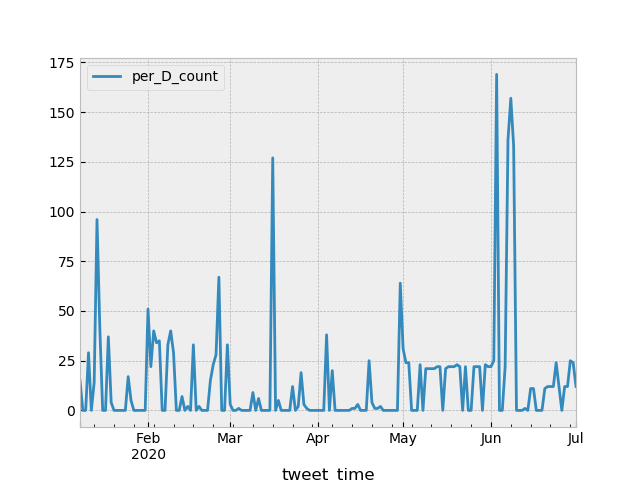

In [13]:
make_timeline((grouped.get_group(c1)),
              'D').plot()

<IPython.core.display.Javascript object>


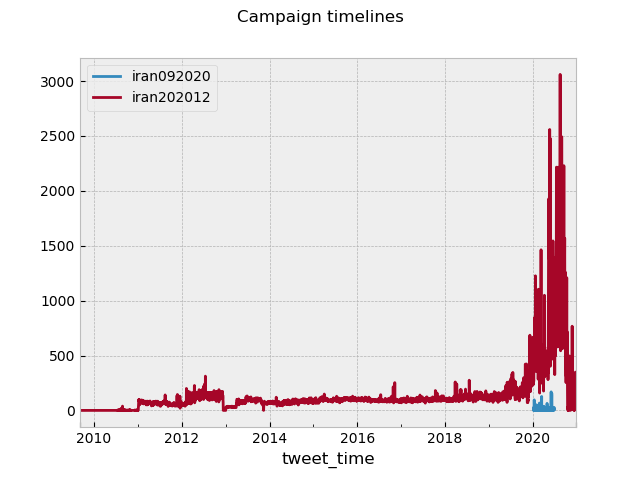

Text(0.5, 0.98, 'Campaign timelines')

In [14]:
fig, ax = plt.subplots()

for group in keys:
    (make_timeline((grouped.get_group(group)),
                  'D')
     .rename(columns={'per_D_count': '{}'.format(group)})
    ).plot(ax=ax)


fig.suptitle('Campaign timelines')

In [15]:
periods

[(Timestamp('2020-01-08 17:43:00'), Timestamp('2020-07-01 07:52:00')),
 (Timestamp('2009-09-06 13:56:00'), Timestamp('2020-12-27 18:08:00'))]

In [16]:
start = periods[0][0]
end = periods[0][1]
mask = (campaign['tweet_time'] >= start) & (campaign['tweet_time'] <= end)
overlap = (campaign
          .loc[mask]
          )
grouped = (overlap
          .groupby('campaign')
          )

In [17]:
grouped.size()

campaign
iran092020      2450
iran202012    111899
dtype: int64

<IPython.core.display.Javascript object>


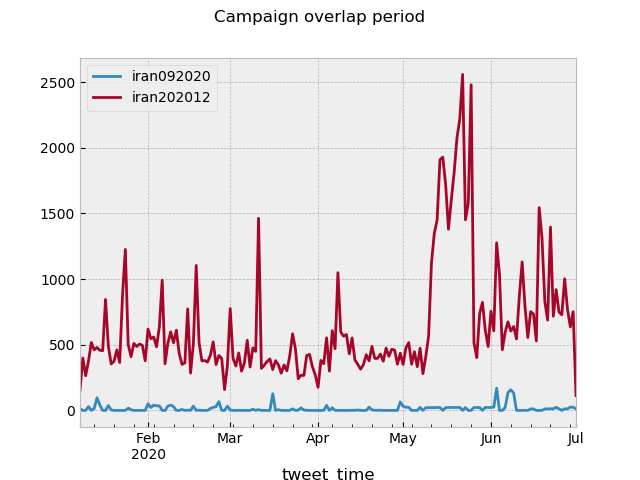

Text(0.5, 0.98, 'Campaign overlap period')

In [18]:
fig, ax = plt.subplots()

for group in keys:
    (make_timeline((grouped.get_group(group)),
                  'D')
     .rename(columns={'per_D_count': '{}'.format(group)})
    ).plot(ax=ax)


fig.suptitle('Campaign overlap period')

<IPython.core.display.Javascript object>


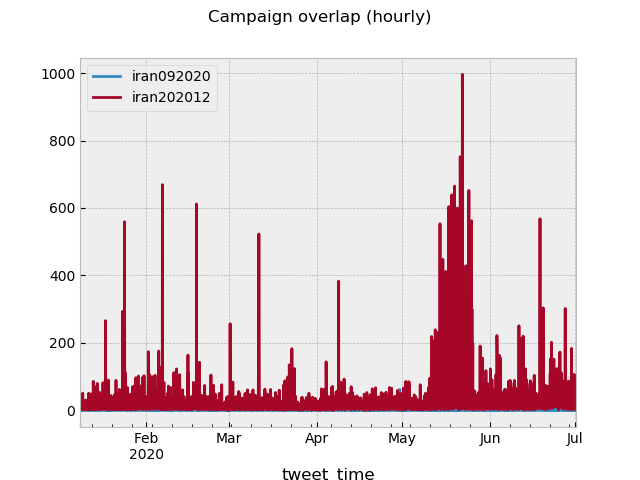

Text(0.5, 0.98, 'Campaign overlap (hourly)')

In [19]:
fig, ax = plt.subplots()

for group in keys:
    (make_timeline((grouped.get_group(group)),
                  'H')
     .rename(columns={'per_H_count': '{}'.format(group)})
    ).plot(ax=ax)


fig.suptitle('Campaign overlap (hourly)')

In [29]:
def top_user(campaign):
    return (campaign
           .groupby('userid')
           .size()
           .idxmax())

def hashtag_list(campaign):
    hashtags = (campaign
               .loc[:]['hashtags']
               .fillna('')
               )
    return [el.strip() for el in long_list(hashtags)
            if el != '']

def top_days(campaign, limit=1):
    grouped = (campaign
             .reset_index()
             .set_index('tweet_time')
             .resample('D')
            )

    return (grouped
             .size()
             .sort_values(ascending=False)
            ).index[:limit]


def original_tweets(tweets):
    is_retweet = tweets['is_retweet'] == False
    return (tweets
            .loc[:][is_retweet]
           )

def retweets(tweets):
    is_retweet = tweets['is_retweet'] == True
    return (tweets
            .loc[:][is_retweet]
           )

def replies(tweets):
    is_reply = tweets['in_reply_to_tweetid'].notna()
    return (tweets
            .loc[:][is_reply]
           )

### Top day for Sept. release campaign

In [64]:
time_group1 = ((grouped.get_group(c1))
             .reset_index()
             .set_index('tweet_time')
             .resample('D')
            )
top_day1 = time_group1.size().sort_values(ascending=False).idxmax()

top_day_tweets = time_group1.get_group(top_day1)[['userid','tweet_text','hashtags']]

In [70]:
top_day_tweets.tweet_text

tweet_time
2020-06-03 00:02:00    #black_lives_matter https://t.co/UJWCaJbPXn
2020-06-03 00:03:00    #black_lives_matter https://t.co/zzJS4kytCW
2020-06-03 14:56:00    #black_lives_matter https://t.co/VAO6kcQrXM
2020-06-03 15:01:00    #black_lives_matter https://t.co/exO1WAHp69
2020-06-03 15:01:00    #black_lives_matter https://t.co/C4Z0QJXDUi
                                          ...                     
2020-06-03 22:38:00    #black_lives_matter https://t.co/4tSzLN1xil
2020-06-03 22:38:00    #black_lives_matter https://t.co/rCiSM9sReR
2020-06-03 22:38:00    #black_lives_matter https://t.co/9JnxstuMb3
2020-06-03 22:38:00    #black_lives_matter https://t.co/qtfuvyDL7Y
2020-06-03 22:43:00    #black_lives_matter https://t.co/y8OlRvhiax
Name: tweet_text, Length: 169, dtype: string

In [27]:
(campaign_users
.loc[campaign_users.index == top_user(grouped.get_group(c1))]
).append(
campaign_users
.loc[campaign_users.index == top_user(grouped.get_group(c2))])

,user_display_name,user_screen_name,user_reported_location,user_profile_description,user_profile_url,follower_count,following_count,account_creation_date,account_language,file,campaign,release,government
userid,,,,,,,,,,,,,
CH8ljNwytxIQAm7r8kH1J9+ykPUzrqe2L5uKhiA2cg=,CH8ljNwytxIQAm7r8kH1J9+ykPUzrqe2L5uKhiA2cg=,CH8ljNwytxIQAm7r8kH1J9+ykPUzrqe2L5uKhiA2cg=,London,I write columns for the Sunday Times and books...,<NA>,352,559,2020-01-25,en,iran_092020_users_csv_hashed,iran092020,092020,iran
213589457,HispanTV,Hispantv,Teherán,"Medio no corporativo, que se hace eco de las r...",http://t.co/SU1GJqdDNM,161512,31,2010-11-09,es,hashed_2020_12_iran_202012_iran_202012_users_c...,iran202012,202012,iran


In [84]:
(campaign
 .loc[campaign['userid'] == top_user(grouped.get_group(c1))]
)['tweet_text'].sample(20).to_list()

['@Avantik57819274 @hernandezjeruz I followed you please follow me.tnx',
 'RT @3nHy7eArolfXp2x: أول تاجر إقامات في الكويت هو المرتزق عبدالحميد دشتي، وهذا كتاب صادر من السفارة الإيرانية إلى وزارة الداخلية الكويتية ت…',
 '@Binibininggab49 @CH8ljNwytxIQAm7r8kH1J9+ykPUzrqe2L5uKhiA2cg=\n\n followe me pls.follow back',
 'RT @PPmXoDvaMUeL1+cFVsRiyzUFy9hTxGMWjjQ0qt5vSg=: I really cannot thank this team of people enough who are currently donating their time, staff &amp; materials to renovate…',
 '@_mmj13_ @yekarlopehlay @_mmj13 @CH8ljNwytxIQAm7r8kH1J9+ykPUzrqe2L5uKhiA2cg=\n\n followe me pls.follow back',
 '@susipioquinto_ I followed you. Please follow me',
 '@Issuvorova I followed you. Please follow me',
 '@jpcasem04 @crnchz @CH8ljNwytxIQAm7r8kH1J9+ykPUzrqe2L5uKhiA2cg=\n followe me pls.follow back',
 '@_LadyLizza @CH8ljNwytxIQAm7r8kH1J9+ykPUzrqe2L5uKhiA2cg=\n\n followe me pls.follow back',
 '@vikastr574 @bishnoi290000 @CH8ljNwytxIQAm7r8kH1J9+ykPUzrqe2L5uKhiA2cg=\n\n followe me pls.follow back',

<IPython.core.display.Javascript object>


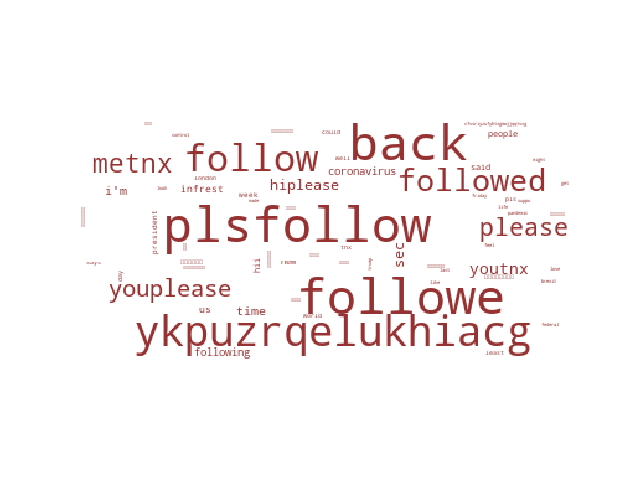

In [74]:
fig = vis_from_series((campaign
                    .loc[campaign['userid'] == top_user(grouped.get_group(c1))]['tweet_text']))

In [86]:
c1_top_user = (campaign
                .loc[campaign['userid'] == top_user(grouped.get_group(c1))]
 )

In [88]:
c1_top_user['user_mentions'].str.split(expand=True)

,0
tweetid,
1269881973880864768,nan
1270229092613468163,nan
1269910694549389313,nan
1269864938522185730,nan
1269882129451749377,nan
...,...
1231558833295806464,nan
1247054749461106689,nan
1223989795531173889,nan


<IPython.core.display.Javascript object>


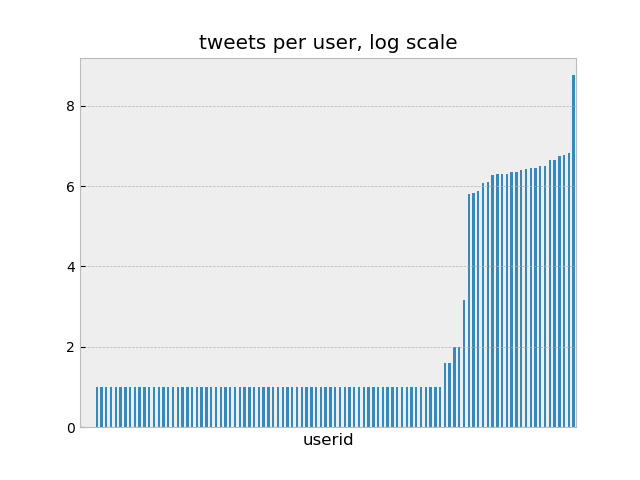

In [81]:
tweet_counts_per_user = ((grouped.get_group(c1))
                        .groupby('userid')
                        .size()
                        .sort_values(ascending=False)
                       )

fig, ax = plt.subplots()

np.log2(tweet_counts_per_user
 .sort_values()
).plot(ax=ax, kind='bar', xticks=([]), title='tweets per user, log scale')

fig.show()